# Import

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

# Data

In [2]:
data = yf.download("SOL-USD", start="2021-04-01", end="2022-04-01")

[*********************100%***********************]  1 of 1 completed


To check the last and first data set in the time series;

In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-27,101.773697,107.298714,99.269096,107.084221,107.084221,1572329892
2022-03-28,107.077965,113.175949,105.477875,106.465256,106.465256,2877146388
2022-03-29,106.327988,115.275719,105.999191,111.710312,111.710312,3052274877
2022-03-30,111.690254,124.605003,107.767258,120.699486,120.699486,3908170428
2022-03-31,120.681557,128.930115,120.197830,122.661461,122.661461,4115229587


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-31,19.101685,19.795801,18.156256,19.465229,19.465229,206011018
2021-04-01,19.415682,20.361540,18.844246,19.084902,19.084902,173731886
2021-04-02,19.084631,19.824574,18.568419,19.810223,19.810223,131061660
2021-04-03,19.796452,23.827188,19.789450,22.552277,22.552277,483057740
2021-04-04,22.527370,25.569532,22.212969,24.061323,24.061323,426557980


Then I saved the adjusted close price of this crytocurrency as a Pandas DataFrame called 'ADJ'

In [5]:
ADJ =  data['Adj Close']

# Plot of Price Movement

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000195BF817AC8>],
      dtype=object)

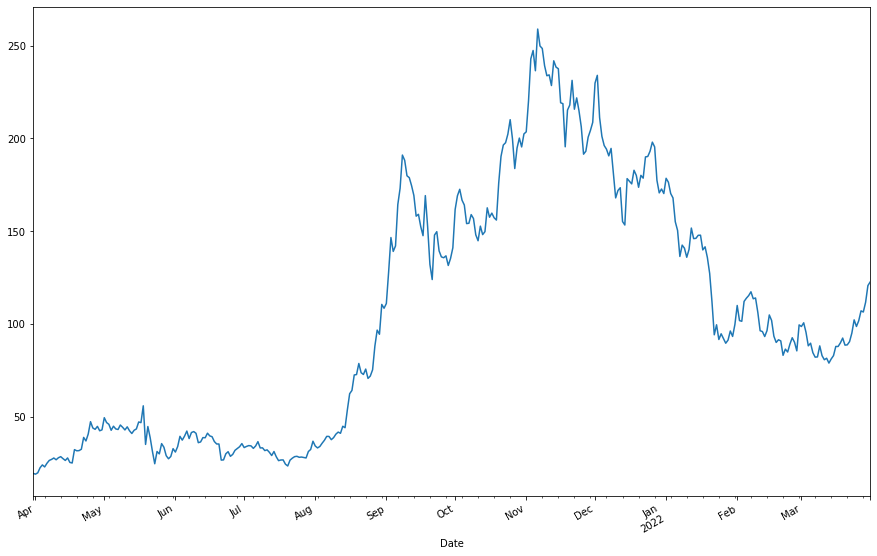

In [9]:
ADJ.plot(figsize=(15, 10), subplots=True)

# Statistical Description

In [10]:
ADJ.describe().round(2)

count    366.00
mean     104.17
std       66.76
min       19.08
25%       38.77
50%       92.92
75%      159.08
max      258.93
Name: Adj Close, dtype: float64

The description above shows a 366 day count, mean price of 104.17 and a standard deviation of 66.76. The minimum and maximum prices being 19.08 and 258.93 respectively. And the first quartile, median and 3rd quartile prices being 38.77, 92.92 and 159.08 respectively.

# Plot: cumulative sum of log return

Firstly, calculate the log return

In [11]:
rets = np.log(ADJ / ADJ.shift(1))
rets.head().round(4)

Date
2021-03-31       NaN
2021-04-01   -0.0197
2021-04-02    0.0373
2021-04-03    0.1296
2021-04-04    0.0648
Name: Adj Close, dtype: float64

Then get the plot to show the cummulative sum of log return

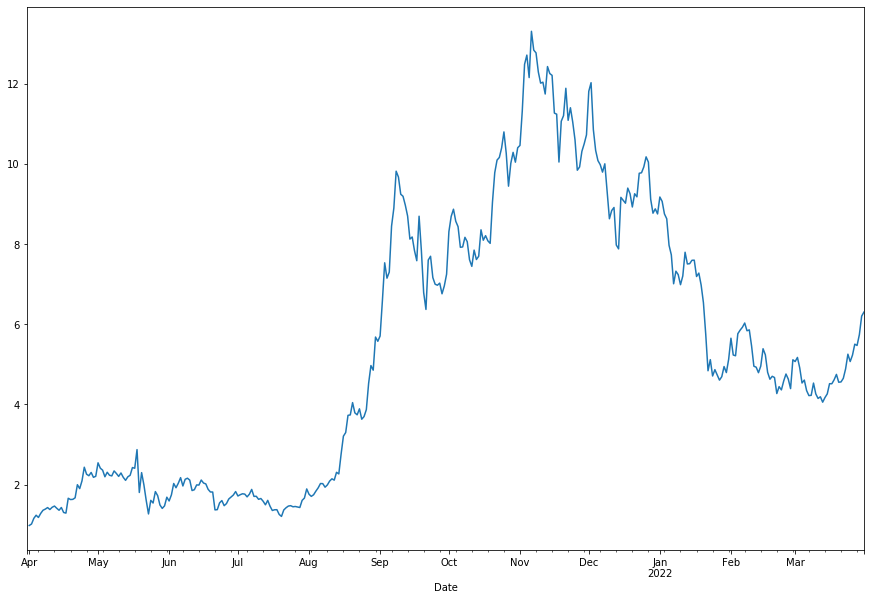

In [13]:
rets.cumsum().apply(np.exp).plot(figsize=(15, 10));

Note that the cumsum starts from 1.

In [14]:
Volatility = np.sqrt(365) * rets.std()

In [15]:
print (Volatility)

1.4166160625504183


# Binomial Tree (CRR Tree)

In [16]:
import numpy as np
import pandas as pd
import os

In [17]:
S0 = 136.00             # spot price
K = 150.0               # strike
T = 0.5                 # maturity 
r = 0.016               # risk free rate 
sig = Volatility        # diffusion coefficient or volatility
N = 4                   # number of periods or number of time steps  
payoff = "put"          # payoff 

Step 1: Create the binomial price tree

In [18]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [19]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [20]:
S

array([[ 136.        ,  224.41663408,  370.3148945 ,  611.06486892,
        1008.33177271],
       [   0.        ,   82.41813302,  136.        ,  224.41663408,
         370.3148945 ],
       [   0.        ,    0.        ,   49.94668126,   82.41813302,
         136.        ],
       [   0.        ,    0.        ,    0.        ,   30.2684722 ,
          49.94668126],
       [   0.        ,    0.        ,    0.        ,    0.        ,
          18.34316889]])

Calculate the risk neutral probability as in below;

In [21]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability

In [22]:
p

0.379258504547379

In [23]:
q

0.6207414954526209

Step 2: Find option value at each final node

In [24]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         14.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        100.05331874],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        131.65683111]])

Step 3: Find option value at earlier nodes

In [25]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 60.02510728,  29.88899881,   5.37294524,   0.        ,
          0.        ],
       [  0.        ,  78.63115482,  44.96413024,   8.67301754,
          0.        ],
       [  0.        ,   0.        ,  99.45451715,  67.28216678,
         14.        ],
       [  0.        ,   0.        ,   0.        , 119.4318276 ,
        100.05331874],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        131.65683111]])

In [26]:
print('European ' + payoff + " is", str( V[0,0].round(4))) 

European put is 60.0251


In [27]:
# for American Option
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
elif payoff =="put":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(K - S[i,j],np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
V

array([[ 60.34198635,  30.00401829,   5.37294524,   0.        ,
          0.        ],
       [  0.        ,  79.07238737,  45.14979489,   8.67301754,
          0.        ],
       [  0.        ,   0.        , 100.05331874,  67.58186698,
         14.        ],
       [  0.        ,   0.        ,   0.        , 119.7315278 ,
        100.05331874],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        131.65683111]])

Always take the maximum value to compare if you can take the early execution or not

Looking and comparing the arrays e.g. where 119.73 is greater than 119.43. This means one can consider early execution at that node. This applies same in the other nodes at the 2nd and 3rd columns.

In [28]:
print('American ' + payoff, str( V[0,0].round(4)))

American put 60.342


# Monte Carlo Simulation

In [29]:
def montecarlo_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * rn[t]) 
    return S

I= number of simulations; M = number of time steps; starting point is S0 (=136)

In [30]:
T = 0.5
r = 0.0166
sig = Volatility
S0 = 136
K = 150

In [31]:
S = montecarlo_simulation_np(10000)

The imput here is 10000; this means there is 10000 number of time steps and 10000 number of simulations

In [32]:
S = np.transpose(S)
S

array([[136.        , 134.88169082, 134.8980435 , ...,  76.66997506,
         76.39520509,  77.01099661],
       [136.        , 135.87841775, 135.81947242, ..., 584.55667246,
        580.35372218, 580.42454559],
       [136.        , 138.30782621, 139.88054037, ...,  21.42648842,
         21.40168781,  21.40756799],
       ...,
       [136.        , 137.17574431, 136.30144447, ..., 132.79548114,
        131.92046724, 131.95309234],
       [136.        , 136.68841101, 137.58777984, ...,  92.09064434,
         93.54133318,  94.11113853],
       [136.        , 135.82135029, 136.25467398, ...,  68.98911782,
         69.49422007,  69.25563186]])

Note: We are concerned about the endpoint i.e. 152.09, 147.09, 107.46 and so on

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-period values')

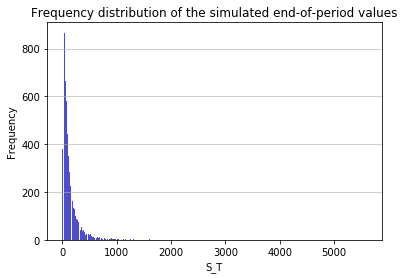

In [33]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')

Then we can find the put and the call options as in below

In [34]:
p = np.mean(np.maximum(K - S[:,-1],0)) * np.exp(-r * T)
print('European put', str(p))

European put 61.52697125175137


In [35]:
c = np.mean(np.maximum(S[:,-1] - K,0)) * np.exp(-r * T)
print('European call', str(c))

European call 50.43604321254649


Note: the future payoff is multiplied by the discount factor i.e. np.exp(-r * T) to get the Present Value

# GREEKS

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

# Delta

Delta, ∆, measures the rate of change of the theoretical option value with respect to changes in the underlying asset's price. Delta is the first derivative of the value V of the option with respect to the underlying instrument's price S.

In [37]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [38]:
delta(136, 150, 0.5, 0.0166, 0, Volatility, 'call')

0.6595814488845351

In [39]:
delta(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

-0.34041855111546493

then we plot the figure;

In [40]:
S = np.linspace(50,150,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(136, 150, 0.5, 0.0166, 0, Volatility, 'call')
    Delta_Put [i] = delta(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

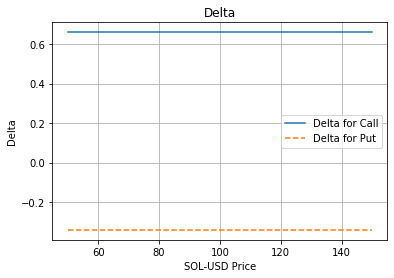

In [41]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('SOL-USD Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

# Gamma

Gamma, Γ, measures the rate of change in the delta with respect to changes in the underlying price. Gamma is the second derivative of the value function with respect to the underlying price.

In [42]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [43]:
gamma(136, 150, 0.5, 0.0166, 0, Volatility, 'call')

0.002690889895276412

In [44]:
gamma(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

0.002690889895276412

In [45]:
S = np.linspace(50,150,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 150, 0.5, 0.0166, 0, Volatility, 'call')

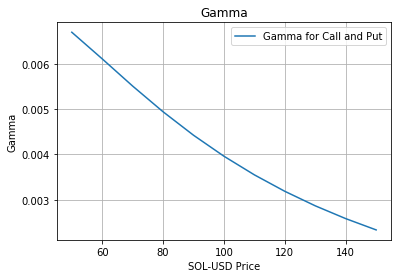

In [46]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('SOL-USD Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

# Speed

Speed measures the rate of change in Gamma with respect to changes in the underlying price.

In [47]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [48]:
speed(136, 150, 0.5, 0.0166, 0, Volatility, 'call')

-1.973572760044714e-05

In [49]:
speed(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

-1.973572760044714e-05

In [50]:
S = np.linspace(50,150,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 150, 0.5, 0.0166, 0, Volatility, 'call')

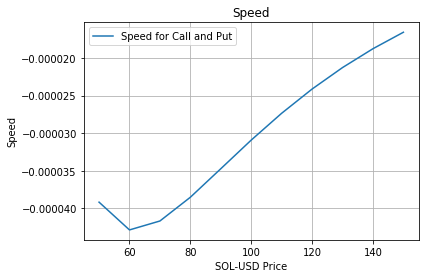

In [51]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('SOL-USD Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

# Theta

Theta, 𝜃, measures the sensitivity of the value of the derivative to the passage of time (see Option time value): the "time decay".

In [52]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [53]:
theta(136, 150, 0.5, 0.0166, 0, Volatility, 'call')

50.62513287372445

In [54]:
theta(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

51.7241786089558

In [55]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(136, 150, 0.5, 0.0166, 0, Volatility, 'call')
    Theta_Put [i] = theta(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

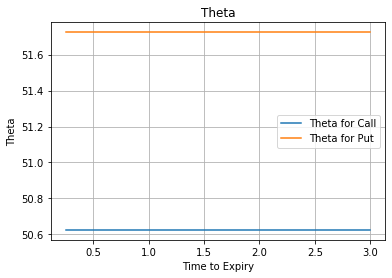

In [56]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

# Rho

Rho, 𝜌, measures sensitivity to the interest rate: it is the derivative of the option value with respect to the risk free interest rate (for the relevant outstanding term

In [57]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [58]:
rho(136, 150, 0.5, 0.0166, 0, Volatility, 'call')

20.63814451835256

In [59]:
rho(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

-53.741931724116085

In [60]:
r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(136, 150, 0.5, r[i], 0, Volatility, 'call')
    Rho_Put [i] = rho(136, 150, 0.5, r[i], 0, Volatility, 'put')

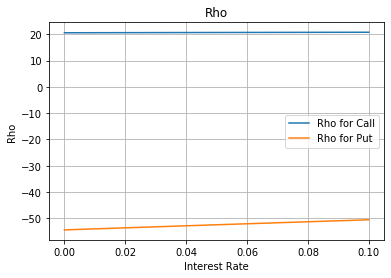

In [61]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

# Vega

Vega measures sensitivity to volatility. Vega is the derivative of the option value with respect to the volatility of the underlying asset.

In [62]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [63]:
vega(136, 150, 0.5, 0.0166, 0, Volatility, 'call')

35.252986180183

In [64]:
vega(136, 150, 0.5, 0.0166, 0, Volatility, 'put')

35.252986180183

In [65]:
vol = np.linspace(0.1,0.4,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(136, 150, 0.5, 0.0166, 0, Volatility, 'call')

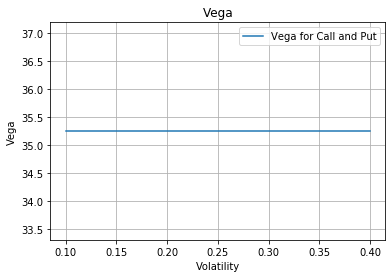

In [66]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])